In [1]:
import machine_learning as ml
import numpy as np
from matplotlib import pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score, average_precision_score, fbeta_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
### Transformer Model Hyperparameters
sequence_length = 25
num_features = 14
model_dim = 64
representation_dim = 128
num_heads = 4
num_layers = 2
batch_size = 64
epochs = 10
learning_rate = 1e-3

# Data preparation

In [3]:
num_samples_train = 5000
data_train = np.random.rand(num_samples_train, sequence_length, num_features)

num_samples_test = 100
data_test_normal = np.random.rand(num_samples_test, sequence_length, num_features)
data_test_anomalous = np.random.rand(num_samples_test, sequence_length, num_features) * 5.0

# Convert to PyTorch tensors
data_train_tensor = torch.tensor(data_train, dtype=torch.float32)
data_test_normal_tensor = torch.tensor(data_test_normal, dtype=torch.float32)
data_test_anomalous_tensor = torch.tensor(data_test_anomalous, dtype=torch.float32)

train_dataset = TensorDataset(data_train_tensor, data_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Train Autoencoder

In [4]:
model = ml.TransformerAutoencoder(
    num_features=num_features,
    model_dim=model_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    representation_dim=representation_dim,
    sequence_length=sequence_length
)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model.train()
for epoch in range(epochs):
    total_loss = 0.0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")

Epoch [1/10], Loss: 0.1124
Epoch [2/10], Loss: 0.0864
Epoch [3/10], Loss: 0.0845
Epoch [4/10], Loss: 0.0842
Epoch [5/10], Loss: 0.0841
Epoch [6/10], Loss: 0.0840
Epoch [7/10], Loss: 0.0839
Epoch [8/10], Loss: 0.0839
Epoch [9/10], Loss: 0.0838
Epoch [10/10], Loss: 0.0838


# Train One-Class SVM

In [5]:
model.eval()
Z_train = model.get_representation(data_train_tensor).numpy()

scaler = StandardScaler()
Z_train_scaled = scaler.fit_transform(Z_train)

# nu = 0.01 assumes that approximately 1% of the training data are outliers
oc_svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01) 
oc_svm.fit(Z_train_scaled)

OneClassSVM(gamma='auto', nu=0.01)

# Anomaly Detection

In [6]:
Z_test_normal = model.get_representation(data_test_normal_tensor).numpy()
Z_test_anomalous = model.get_representation(data_test_anomalous_tensor).numpy()

Z_test_normal_scaled = scaler.transform(Z_test_normal)
Z_test_anomalous_scaled = scaler.transform(Z_test_anomalous)

X_test_scaled = np.concatenate([Z_test_normal_scaled, Z_test_anomalous_scaled], axis=0)

y_true_normal = np.zeros(num_samples_test)
y_true_anomalous = np.ones(num_samples_test)
y_true = np.concatenate([y_true_normal, y_true_anomalous], axis=0)

scores_svm = oc_svm.score_samples(X_test_scaled)
anomaly_scores = -scores_svm

predictions_svm = oc_svm.predict(X_test_scaled)
y_pred = np.where(predictions_svm == -1, 1, 0)

AUROC: 1.0000
AUPRC: 1.0000
F-beta Score (beta=4): 0.9988
Confusion Matrix:
Normal is ones, Anomalous is zeros


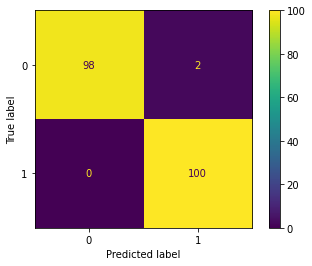

In [7]:
# AUROC
auc_roc = roc_auc_score(y_true, anomaly_scores)
print(f"AUROC: {auc_roc:.4f}")

# AUPRC
auc_pr = average_precision_score(y_true, anomaly_scores)
print(f"AUPRC: {auc_pr:.4f}")

# F-beta Score
f4 = fbeta_score(y_true, y_pred, beta=4)
print(f"F-beta Score (beta=4): {f4:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print("Normal is ones, Anomalous is zeros")
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])
cm_display.plot()
plt.show()